In [1]:
import numpy as np
# import pandas as pd
# from scipy.stats import zscore
# from scipy import sparse 
# from scipy.spatial import ConvexHull
# from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

import anndata as sc
# from py_pcha import PCHA

from sca import SingleCellArchetype
from utils import plot_archetype

In [2]:
adata = sc.read('../../data/cheng21_cell_scrna/reorganized/P28NR_L23_forPCHA_n286genes.h5ad')
adata

AnnData object with n_obs × n_vars = 4044 × 286
    obs: 'Class_broad', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'cond'
    layers: 'lognorm', 'norm'

In [3]:
# set up
x = np.array(adata.X.todense())
depths = adata.obs['n_counts'].values
types = adata.obs['Type'].values

sca = SingleCellArchetype(x, depths, types)

# do and shuffle

In [4]:
ndim = 2
noc = 3
sca.setup_feature_matrix(method='data')
xp, aa = sca.proj_and_pcha(ndim, noc)

nrepeats = 3
p = 0.8
aa_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use data


In [5]:
# gshuff
sca.setup_feature_matrix(method='gshuff')
xp_gshuff, aa_gshuff = sca.proj_and_pcha(ndim, noc)
aa_gshuff_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use shuffled data


In [6]:
# tshuff 
sca.setup_feature_matrix(method='tshuff')
xp_tshuff, aa_tshuff = sca.proj_and_pcha(ndim, noc)
aa_tshuff_dsamps = sca.downsamp_proj_pcha(ndim, noc, nrepeats=nrepeats, p=p)

use per-type shuffled data


# plot

In [7]:
types_colorvec = np.char.add('C', sca.types_idx.astype(str))

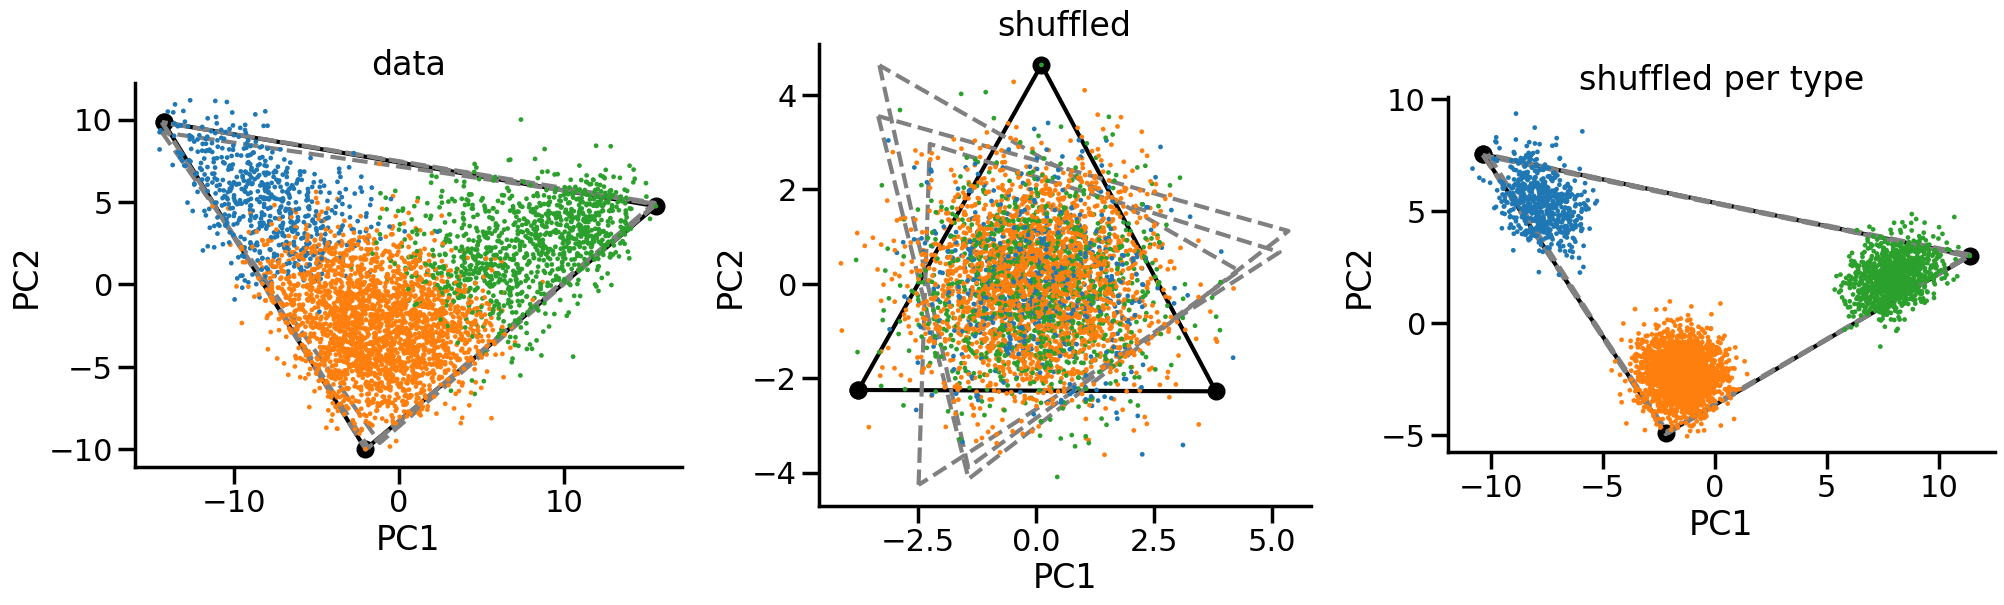

In [8]:
# plot
fig, axs = plt.subplots(1,3,figsize=(8*3,6))
ax = axs[0]
ax.scatter(xp[:,0], xp[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa, fmt='-o', color='k', zorder=0)
for i in range(nrepeats):
    plot_archetype(ax, aa_dsamps[i], fmt='--', color='gray', zorder=0)
ax.set_title('data')
    
ax = axs[1]
ax.set_title('shuffled')
ax.scatter(xp_gshuff[:,0], xp_gshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_gshuff, fmt='-o', color='k', zorder=0)
for i in range(nrepeats):
    plot_archetype(ax, aa_gshuff_dsamps[i], fmt='--', color='gray', zorder=0)

ax = axs[2]
ax.set_title('shuffled per type')
ax.scatter(xp_tshuff[:,0], xp_tshuff[:,1], c=types_colorvec, s=2)
plot_archetype(ax, aa_tshuff, fmt='-o', color='k', zorder=0)
for i in range(nrepeats):
    plot_archetype(ax, aa_tshuff_dsamps[i], fmt='--', color='gray', zorder=0)

for i in range(3):
    ax = axs[i]
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_aspect('equal')
    sns.despine(ax=ax)
    ax.grid(False)
    
plt.show()

# quantify t-ratio 

- for 2-dimensional data only

In [9]:
t_ratio, t_ratio_shuffs, pval = sca.t_ratio_test(ndim, noc, nrepeats=20)
print(f'p-value: {pval}')

use data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
use shuffled data
p-value: 0.05


In [10]:
fig, ax = plt.subplots()
ax.axvline(t_ratio, color='k', label='data')
sns.histplot(t_ratio_shuffs, ax=ax, stat='density', label='shuffled')
ax.set_xlabel('t-ratio')
ax.legend()
sns.despine(ax=ax)
plt.show()


KeyboardInterrupt



# quantify stability

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
def get_relative_variation(aa_list):
    """
    """
    
    aa_avg = np.mean(aa_list, axis=0).T
    ref = np.mean(pairwise_distances(aa_avg))

    aa_std = np.std(aa_list, axis=0).T
    epsilon = np.mean(np.sqrt(np.sum(np.power(aa_std,2), axis=1)))
    
    return epsilon/ref

In [ ]:
var_data   = get_relative_variation(aa_dsamps)
var_gshuff = get_relative_variation(aa_gshuff_dsamps)

In [ ]:
fig, ax = plt.subplots(figsize=(2,5))
ax.bar(np.arange(2), [var_data, var_gshuff])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['data', 'shuffled'])
ax.set_ylabel('Archetype variation\n(higher being less stable)')
plt.show()